# EDA of Jane Street
- Explore how to do `fillna`

- Main reference: https://www.kaggle.com/carlmcbrideellis/jane-street-eda-of-day-0-and-feature-importance

In [84]:
import os, sys
from utils import *
import datatable as dt
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", context="talk")
from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

HOME = os.path.abspath('.')
MODEL_DIR = os.path.join(HOME,  'models')
DATA_DIR = os.path.join(HOME,  'data')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 10)
pd.set_option('display.expand_frame_repr',False)
pd.set_option('max_colwidth', 20)

In [88]:
train_parquet = os.path.join(DATA_DIR, 'train.parquet')
train_data = pd.read_parquet(train_parquet)
train_data = train_data.query('date > 85').reset_index(drop=True)

feat_cols = [f'feature_{i}' for i in range(130)]
resp_cols = ['resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4']
target_cols = ['action_0', 'action_1', 'action_2', 'action_3', 'action_4']

In [55]:
nan_valus_count = train_data.isna().sum(axis=0)
for idx, val in nan_valus_count.items():
    if val > 0:
        print(f'Column: {idx}\t NaNs: {val}')


Column: feature_3	 NaNs: 136
Column: feature_4	 NaNs: 136
Column: feature_7	 NaNs: 312513
Column: feature_8	 NaNs: 312513
Column: feature_9	 NaNs: 631
Column: feature_10	 NaNs: 631
Column: feature_11	 NaNs: 63821
Column: feature_12	 NaNs: 63821
Column: feature_13	 NaNs: 12560
Column: feature_14	 NaNs: 12560
Column: feature_15	 NaNs: 5588
Column: feature_16	 NaNs: 5588
Column: feature_17	 NaNs: 314408
Column: feature_18	 NaNs: 314408
Column: feature_19	 NaNs: 631
Column: feature_20	 NaNs: 631
Column: feature_21	 NaNs: 64980
Column: feature_22	 NaNs: 64980
Column: feature_23	 NaNs: 12560
Column: feature_24	 NaNs: 12560
Column: feature_25	 NaNs: 5588
Column: feature_26	 NaNs: 5588
Column: feature_27	 NaNs: 314408
Column: feature_28	 NaNs: 314408
Column: feature_29	 NaNs: 631
Column: feature_30	 NaNs: 631
Column: feature_31	 NaNs: 64980
Column: feature_32	 NaNs: 64980
Column: feature_33	 NaNs: 12560
Column: feature_34	 NaNs: 12560
Column: feature_35	 NaNs: 5588
Column: feature_36	 NaNs: 55



In the notebook ["*Jane Street: time horizons and volatilities*"](https://www.kaggle.com/pcarta/jane-street-time-horizons-and-volatilities) written by [pcarta](pcarta), if I understand correctly, by using [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) it is calculated that if the time horizon $(T_j$) for `resp_1` (*i.e.* $T_1$) is 1, then 
* $T_j($ `resp_2` $) ~\approx 1.4 ~T_1$
* $T_j($ `resp_3` $) ~\approx 3.9 ~T_1$ 
* $T_j($ `resp_4` $) ~\approx 11.1 ~T_1$

where $T_1$ could correspond to 5 trading days.

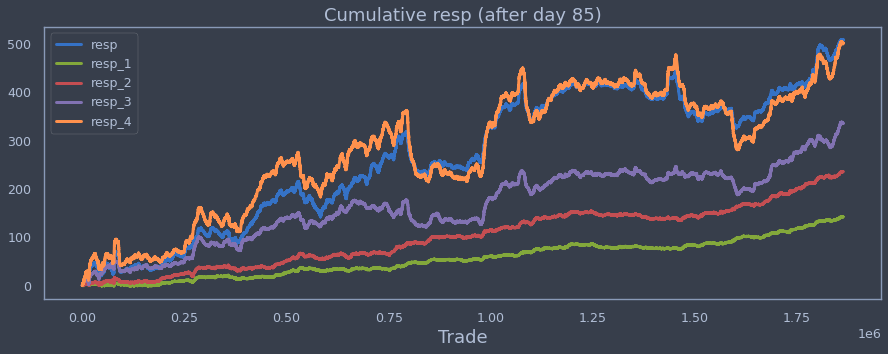

In [56]:
fig, ax = plt.subplots(figsize=(15, 5))
resp= pd.Series(train_data['resp']).cumsum()
resp_1= pd.Series(train_data['resp_1']).cumsum()
resp_2= pd.Series(train_data['resp_2']).cumsum()
resp_3= pd.Series(train_data['resp_3']).cumsum()
resp_4= pd.Series(train_data['resp_4']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative resp (after day 85)", fontsize=18)
resp.plot(lw=3)
resp_1.plot(lw=3)
resp_2.plot(lw=3)
resp_3.plot(lw=3)
resp_4.plot(lw=3)
plt.legend(loc="upper left");
del resp_1, resp_2, resp_3, resp_4
gc.collect();

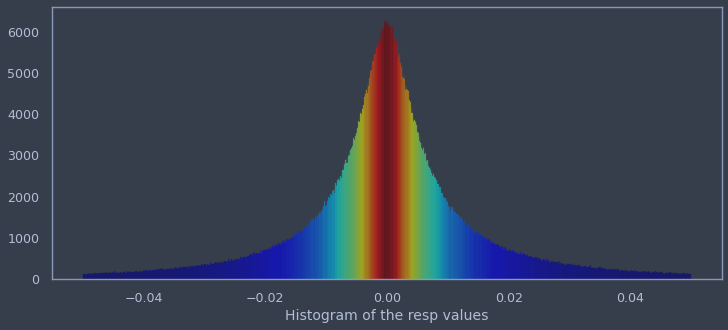

In [68]:
plt.figure(figsize = (12,5))
ax = sns.distplot(train_data['resp'], 
             bins=1500, 
             kde_kws={"clip":(-0.05,0.05)}, 
             hist_kws={"range":(-0.05,0.05)},
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of the resp values", size=14)
plt.show();

In [59]:
print(f"Skew of resp is:     {train_data['resp'].skew():.4f}"  )  # positive skew slightly
print(f"Kurtosis of resp is: {train_data['resp'].kurtosis():.4f}") # long tail!

Skew of resp is:     0.0278
Kurtosis of resp is: 18.4998


In [65]:
percent_zeros = (100*(train_data.weight.values == 0).sum()/train_data.shape[0])
print(f'Percentage of zero weights is: {percent_zeros:.1f} %')

Percentage of zero weights is: 15.6 %


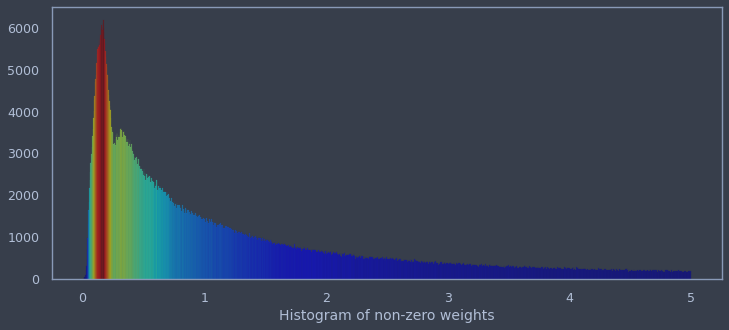

In [67]:
plt.figure(figsize = (12,5))
ax = sns.distplot(train_data['weight'], 
             bins=1400, 
             kde_kws={"clip":(0.001,5)}, 
             hist_kws={"range":(0.001,5)},
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of non-zero weights", size=14)
plt.show();
del values

The cumulative daily return over time, which is given by `weight` multiplied by the value of `resp`, when `action` is taken regardless of the `resp`.

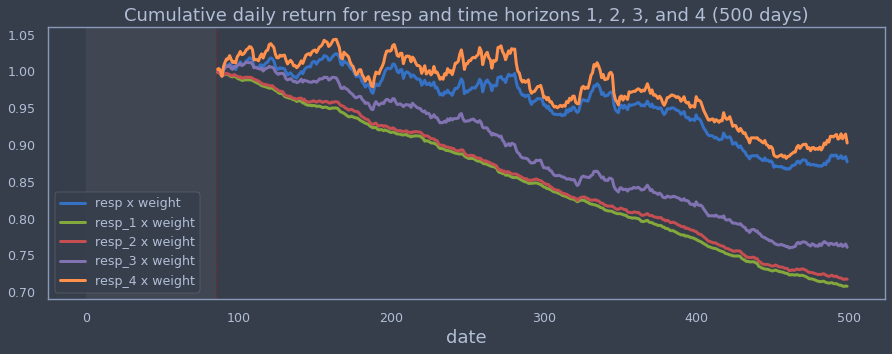

In [69]:
train_data['weight_resp']   = train_data['weight']*train_data['resp']
train_data['weight_resp_1'] = train_data['weight']*train_data['resp_1']
train_data['weight_resp_2'] = train_data['weight']*train_data['resp_2']
train_data['weight_resp_3'] = train_data['weight']*train_data['resp_3']
train_data['weight_resp_4'] = train_data['weight']*train_data['resp_4']

fig, ax = plt.subplots(figsize=(15, 5))
resp    = pd.Series(1+(train_data.groupby('date')['weight_resp'].mean())).cumprod()
resp_1  = pd.Series(1+(train_data.groupby('date')['weight_resp_1'].mean())).cumprod()
resp_2  = pd.Series(1+(train_data.groupby('date')['weight_resp_2'].mean())).cumprod()
resp_3  = pd.Series(1+(train_data.groupby('date')['weight_resp_3'].mean())).cumprod()
resp_4  = pd.Series(1+(train_data.groupby('date')['weight_resp_4'].mean())).cumprod()
ax.set_xlabel ("Day", fontsize=18)
ax.set_title ("Cumulative daily return for resp and time horizons 1, 2, 3, and 4 after day 85)", fontsize=18)
resp.plot(lw=3, label='resp x weight')
resp_1.plot(lw=3, label='resp_1 x weight')
resp_2.plot(lw=3, label='resp_2 x weight')
resp_3.plot(lw=3, label='resp_3 x weight')
resp_4.plot(lw=3, label='resp_4 x weight')
# day 85 marker
ax.axvline(x=85, linestyle='--', alpha=0.3, c='red', lw=1)
ax.axvspan(0, 85 , color=sns.xkcd_rgb['grey'], alpha=0.1)
plt.legend(loc="lower left");

The number of trades per day (it has been [suggested](https://www.kaggle.com/c/jane-street-market-prediction/discussion/201930#1125847) that the number of trades per day is an indication of the [volatility](https://www.investopedia.com/terms/v/volatility.asp) that day)

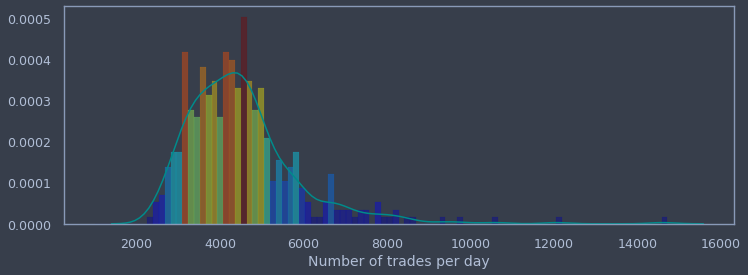

In [76]:
trades_per_day = train_data.groupby(['date'])['ts_id'].count()
plt.figure(figsize = (12,4))
# the minimum has been set to 1000 so as not to draw the partial days like day 2 and day 294
# the maximum number of trades per day is 18884
# I have used 125 bins for the 500 days
ax = sns.distplot(trades_per_day, 
             bins=100, 
             kde_kws={"clip":(1000,15000)}, 
             hist_kws={"range":(1000,15000)},
             color='darkcyan', 
             kde=True);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Number of trades per day", size=14)
plt.show();

Can we use `trades_per_day` to track volatility?

In [85]:
volitile_days = pd.DataFrame(trades_per_day[trades_per_day > 6000])
volitile_days.T

date    153    161    168   185   196   203   223   231   235   262   267   274   276   283   324   343   346   353   354   356   360   363   379   380   382   393   394   427   438   452   454    459   462   468   470   475   483   488   489   491   492   495
ts_id  6399  12064  10607  6983  8107  6134  6959  8271  6738  6689  6487  7839  7812  7317  6791  6271  8584  6504  7048  6688  6176  6035  6545  7930  6704  6678  7020  7205  6610  9294  7300  14603  9718  7512  6030  8484  6068  7829  6879  6658  7524  8251

# Feature 0


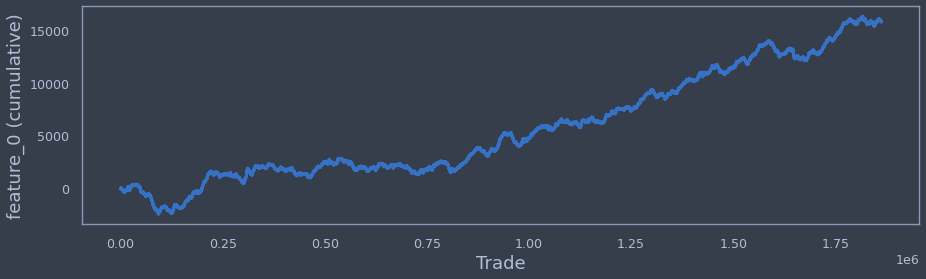

In [90]:
fig, ax = plt.subplots(figsize=(15, 4))
feature_0 = pd.Series(train_data['feature_0']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_ylabel ("feature_0 (cumulative)", fontsize=18);
feature_0.plot(lw=3);

The cumulative `resp` and return (`resp`\*`weight`) for `feature_0 = +1` and `feature_0 = -1` individually (Credit: ["*An observation about feature_0*"](https://www.kaggle.com/c/jane-street-market-prediction/discussion/204963) by [therocket290](https://www.kaggle.com/therocket290))

It can be seen that "+1" and the "-1" projections describe very different return dynamics.
In the notebook ["*Feature 0, beyond feature 0*"](https://www.kaggle.com/nanomathias/feature-0-beyond-feature-0) written by [NanoMathias](https://www.kaggle.com/nanomathias) a [uniform manifold approximation and projection (UMAP)](https://arxiv.org/abs/1802.03426) is performed and shows that `feature_0`  effectively classifies two distributions of features.
There have been many suggestions made regarding the nature of this feature on the discussion topic ["*What is "feature_0" ?*"](https://www.kaggle.com/c/jane-street-market-prediction/discussion/199462) such as `feature_0` representing the direction of the trade or things like bid/ask, long/short, or call/put.

One possibility is that `feature_0` represents something similar to the [Lee and Ready 'Tick' model](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1540-6261.1991.tb02683.x) for classifying individual trades as market buy or market sell orders, using intraday trade and quote data.
A buy initiated trade is labeled as "1", and a sell-initiated trade is labeled as "-1" (*Source*: § 19.3.1 of ["*Advances in Financial Machine Learning*"](https://www.wiley.com/en-es/Advances+in+Financial+Machine+Learning-p-9781119482109) by Marcos Lopez de Prado)

$$
b_t = 
\begin{cases} 
  1  & \mbox{if }\Delta p_t > 0\\
  -1 & \mbox{if }\Delta p_t < 0\\
  b_{t-1} & \mbox{if }\Delta p_t = 0
\end{cases}
$$

where $p_t$ is the price of the trade indexed by $t = 1,\ldots , T$, and $b_0$ is arbitrarily set to
1.

If we look at the correlation matrix (see below) it can be seen that there is a strong positive correlation between `feature_0` and the **Tag 12** features, a strong negative correlation with the **Tag 13** features. There is also a negative correlation with the **Tag 25** and **Tag 27** features, and a positive correlation with  the **Tag 24** features.

Other than features 37, 38, 39 and 40 all of the above features are `resp` related features (see below) with the strongest correlation being with the `resp_4` features.

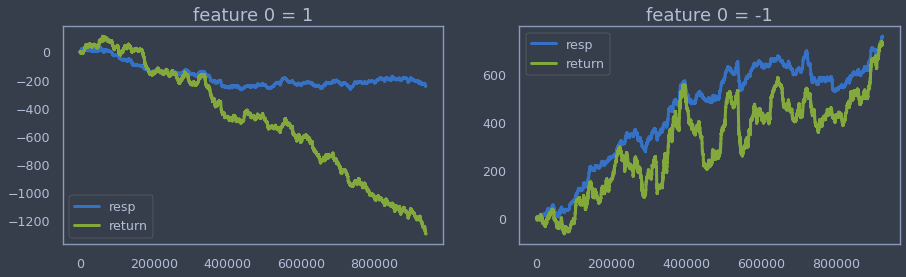

In [91]:
feature_0_is_plus_one  = train_data.query('feature_0 ==  1').reset_index(drop = True)
feature_0_is_minus_one = train_data.query('feature_0 == -1').reset_index(drop = True)
# the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot((pd.Series(feature_0_is_plus_one['resp']).cumsum()), lw=3, label='resp')
ax1.plot((pd.Series(feature_0_is_plus_one['resp']*feature_0_is_plus_one['weight']).cumsum()), lw=3, label='return')

ax2.plot((pd.Series(feature_0_is_minus_one['resp']).cumsum()), lw=3, label='resp')
ax2.plot((pd.Series(feature_0_is_minus_one['resp']*feature_0_is_minus_one['weight']).cumsum()), lw=3, label='return')
ax1.set_title ("feature 0 = 1", fontsize=18)
ax2.set_title ("feature 0 = -1", fontsize=18)
ax1.legend(loc="lower left")
ax2.legend(loc="upper left");

del feature_0_is_plus_one, feature_0_is_minus_one
gc.collect();

# `feature_{1...129}`
Four general 'types' of features.

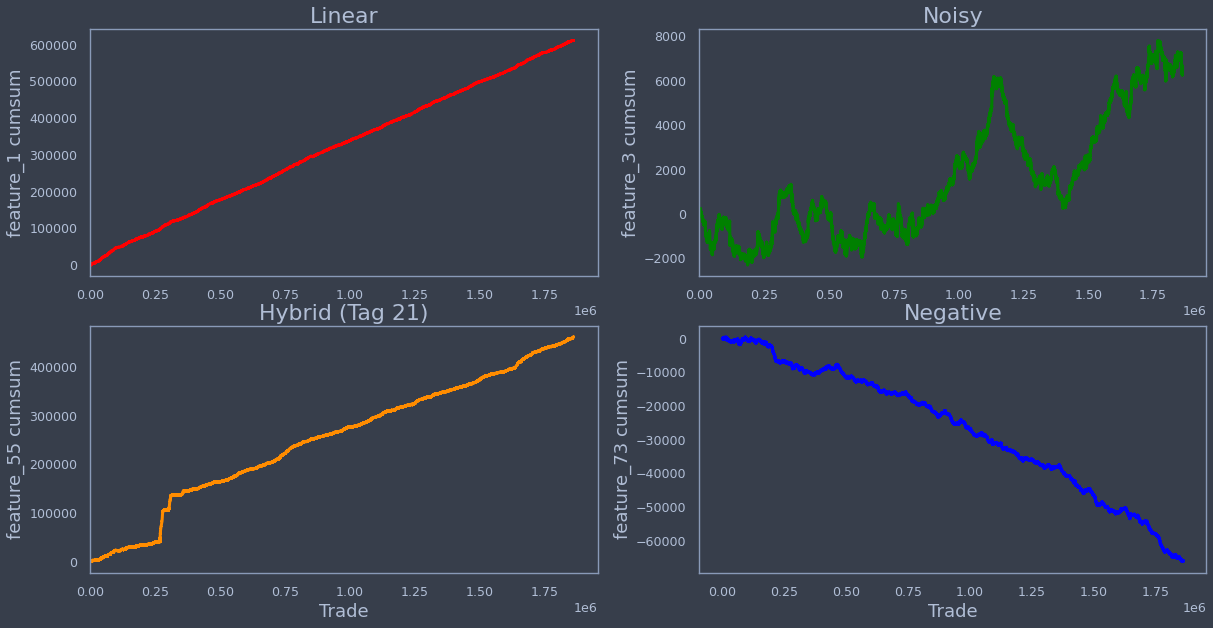

In [94]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20,10))

ax1.plot((pd.Series(train_data['feature_1']).cumsum()), lw=3, color='red')
ax1.set_title ("Linear", fontsize=22);
# ax1.axvline(x=514052, linestyle='--', alpha=0.3, c='green', lw=2)
# ax1.axvspan(0, 514052 , color=sns.xkcd_rgb['grey'], alpha=0.1)
ax1.set_xlim(xmin=0)
ax1.set_ylabel ("feature_1 cumsum", fontsize=18);

ax2.plot((pd.Series(train_data['feature_3']).cumsum()), lw=3, color='green')
ax2.set_title ("Noisy", fontsize=22);
# ax2.axvline(x=514052, linestyle='--', alpha=0.3, c='red', lw=2)
# ax2.axvspan(0, 514052 , color=sns.xkcd_rgb['grey'], alpha=0.1)
ax2.set_xlim(xmin=0)
ax2.set_ylabel ("feature_3 cumsum", fontsize=18);

ax3.plot((pd.Series(train_data['feature_55']).cumsum()), lw=3, color='darkorange')
ax3.set_title ("Hybrid (Tag 21)", fontsize=22);
ax3.set_xlabel ("Trade", fontsize=18)
ax3.set_xlim(xmin=0)
ax3.set_ylabel ("feature_55 cumsum", fontsize=18);

ax4.plot((pd.Series(train_data['feature_73']).cumsum()), lw=3, color='blue')
ax4.set_title ("Negative", fontsize=22)
ax4.set_xlabel ("Trade", fontsize=18)
ax4.set_ylabel ("feature_73 cumsum", fontsize=18);
gc.collect();

# 'Linear' features
* 1 
* 7, 9, 11, 13, 15
* 17, 19, 21, 23, 25
* 18,  20,  22,  24, 26
* 27, 29, 21, 33, 35
* 28, 30, 32, 34, 36
* 84, 85, 86, 87, 88
* 90, 91, 92, 93, 94
* 96, 97, 98, 99, 100
* 102 (strong change in gradient), 103, 104, 105, 106

as well as
41, 46, 47, 48, 49, 50, 51, 53, 54, 69, 89, 95 (strong change in gradient), 101, 107 (strong change in gradient), 108, 110, 111, 113, 114, 115, 116, 117, 118, 119 (strong change in gradient), 120, 122, and 124.

## Features 41, 42 and 43 (Tag 14)
The **Tag 14** set are interesting as they appear to be "stratified"; only adopting discrete values throughout the day (could these be a value of a [security](https://en.wikipedia.org/wiki/Security_(finance)).
Here are scatter plots of these three features for days 0, 1 and 3 (Note that I have omitted day 2, which I shall discuss in the *missing data* section below):